# Sharpe: Daily data; Age > 90 and Age > 180

In [1]:
source("JupyterUtils.R")
source("C2ScoreHypothesisPresentation.R")

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        2007      424419     -0.8040      0.0000     0.04134     0.04386     0.08419      1.0376     0.07574 


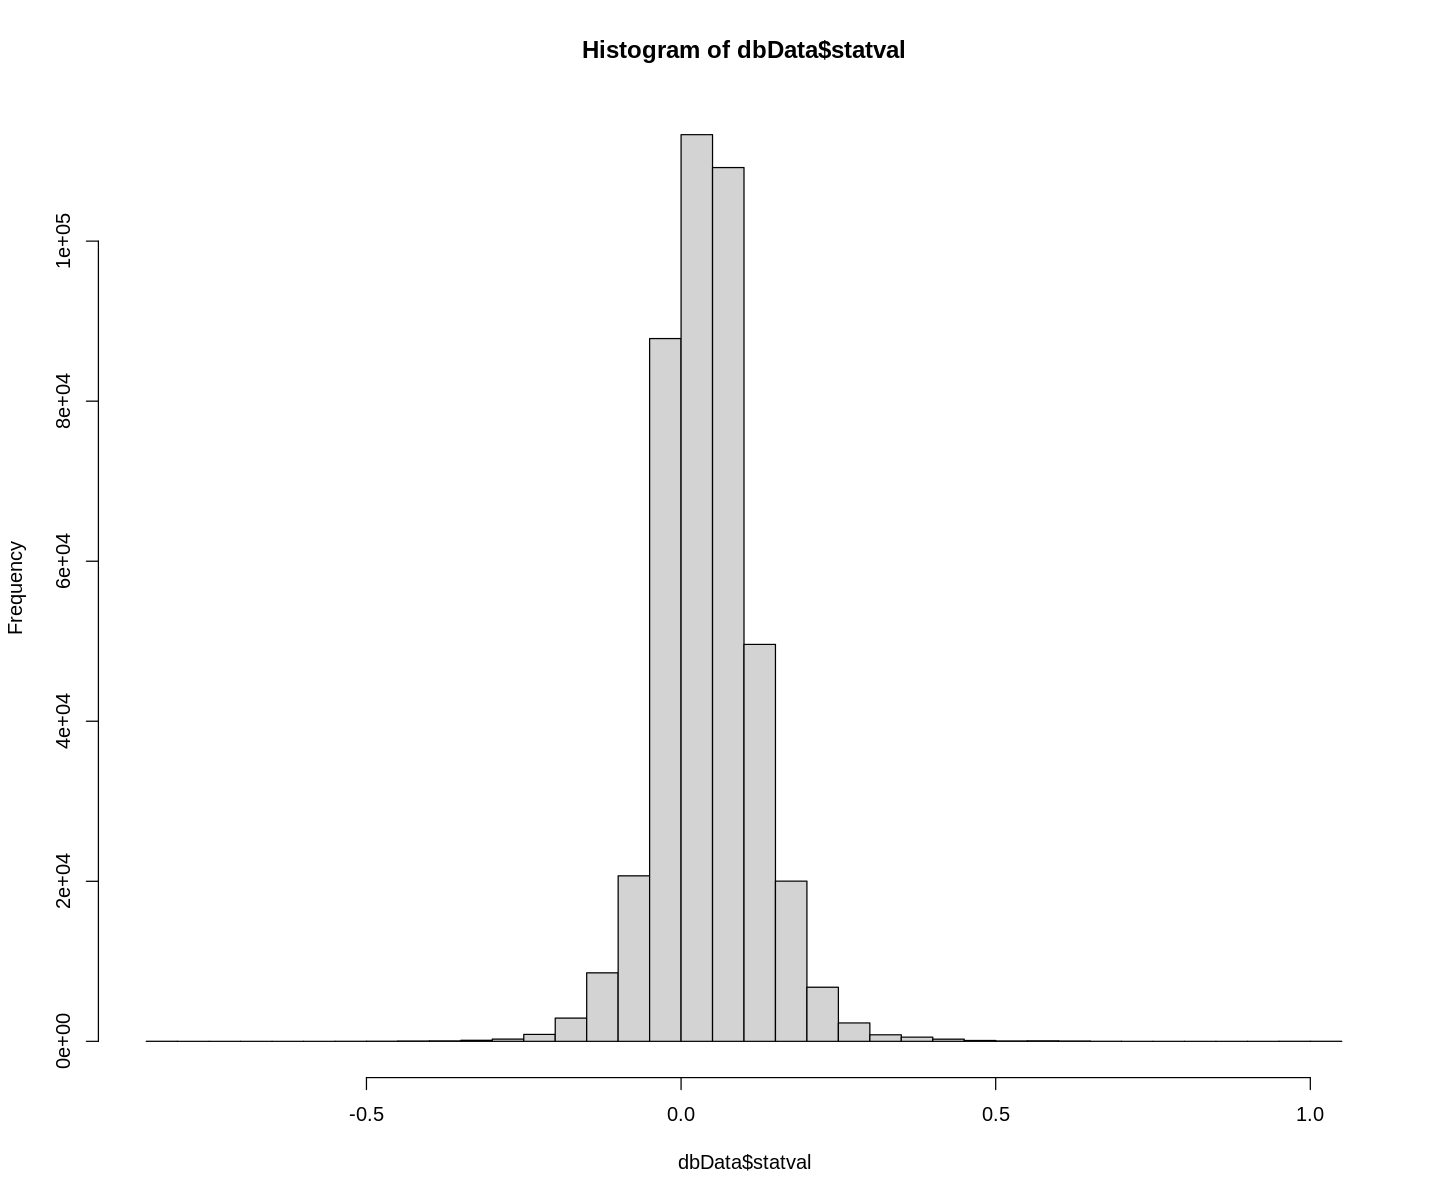

In [2]:
# Stats overview
sql = "select Sharpe as statval, s.systemid  
       from c2score_sharpe s
       join c2systems sys on s.systemid=sys.guid 
       where (DATEDIFF(s.date, Date(from_unixtime(added))) + 1) > 90"
dbData = getC2ScoreDbData(sql)
overview(dbData)
hist(dbData$statval,breaks=50)

Our daily Sharpe has much narrower variance than Sharpe calculated on Collective2. 
- If a system is older than 30 days, Sharpe is not calculated from the first 30 days, where standard deviation is not yet stabilized. 
- Systems younger than 7 days are excluded entirely. 
- And, it is not annualized. We have too many too young systems and annualization means excessive extrapolation from insufficient number of observations. 
- It should be mentioned that original Sharpe definition works with months and years. See http://web.stanford.edu/~wfsharpe/art/sr/SR.htm
>To maximize information content, it is usually desirable to measure risks and returns using fairly short (e.g. monthly) periods. For purposes of standardization it is then desirable to annualize the results. 

- And finally: Age > 90 in this selection.


The procedure used for daily Sharpe calculations is from this library https://github.com/braverock/PerformanceAnalytics

and it is called like this: `SharpeRatio(R,FUN="StdDev")`

(Which means `annualize = FALSE` and risk free rate is zero.)


     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        1597      303061     4.3e-07     0.03472     0.06369     0.07633      0.1035      0.9728     0.05834 


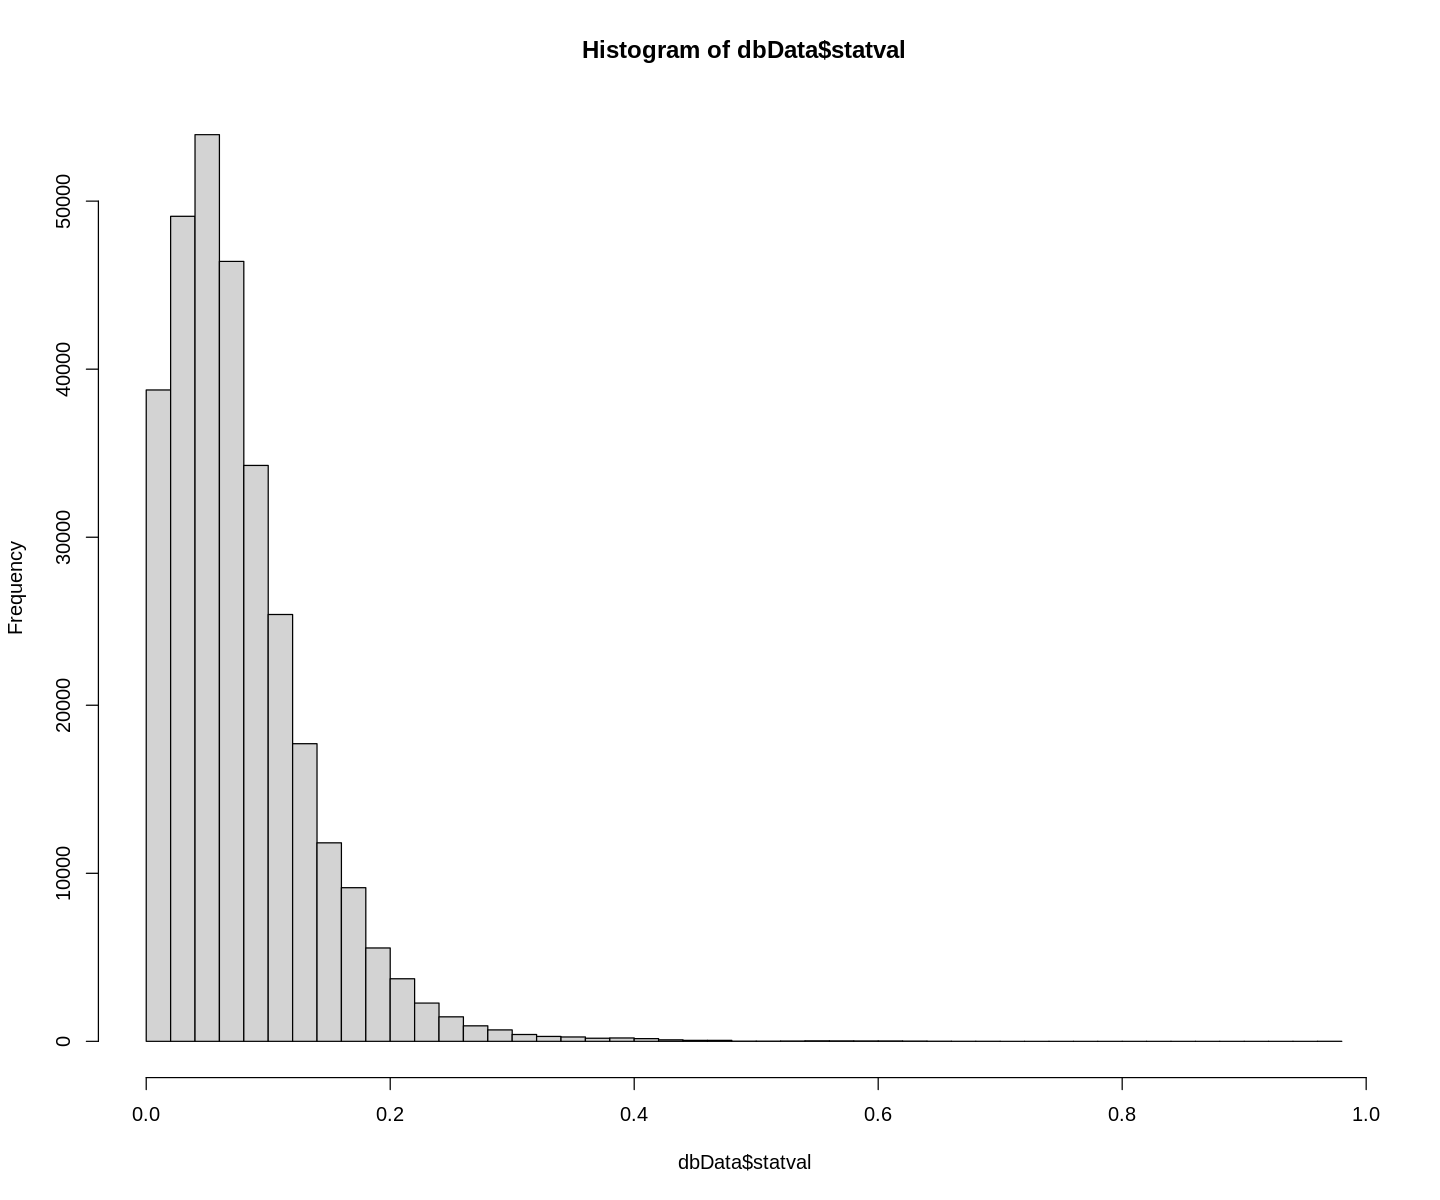

In [3]:
#Let's get Sharpe > 0.1 and Sharpe <= 1

sql = "select Sharpe as statval, s.systemid  
       from c2score_sharpe s
       join c2systems sys on s.systemid=sys.guid 
       where (DATEDIFF(s.date, Date(from_unixtime(added))) + 1) > 90
             and Sharpe > 0 and Sharpe <= 1"

dbData = getC2ScoreDbData(sql)
overview(dbData)
hist(dbData$statval,breaks=50)

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
         968       80170      0.1000      0.1155      0.1360      0.1520      0.1710      0.6813     0.05446 


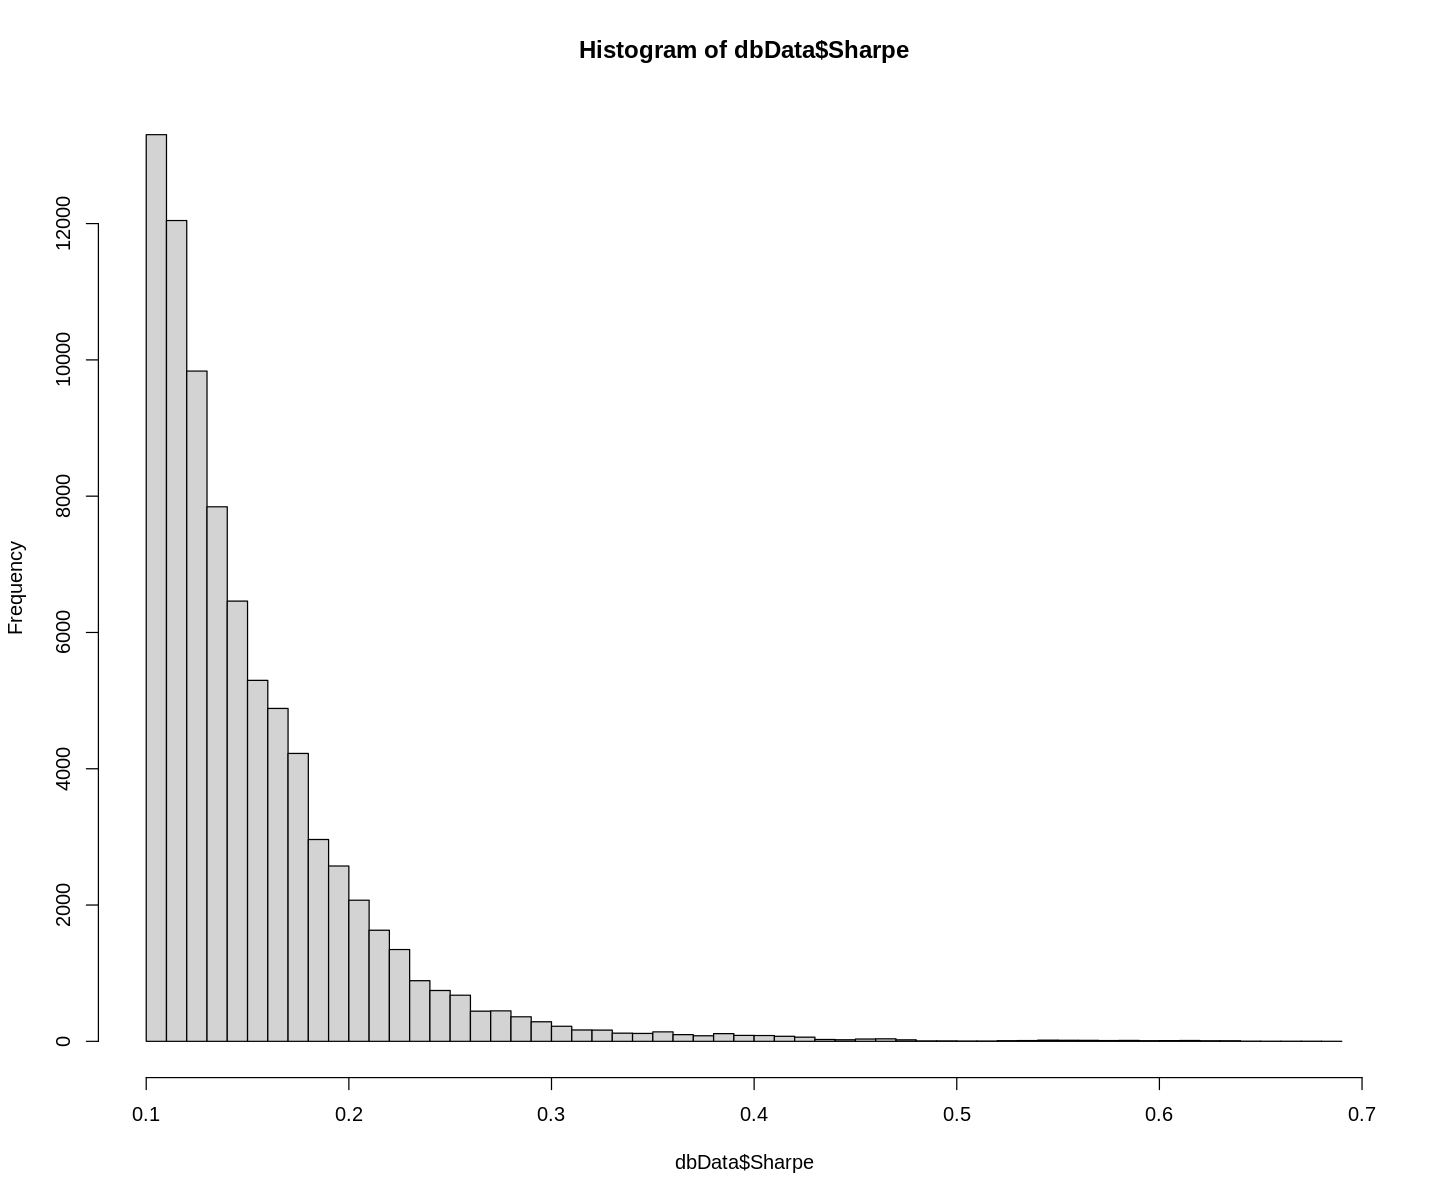

In [4]:
# Join it with our cleaned data
sql = "select Sharpe, r.* 
       from ReturnsDataInIntervalsCleanedSkip090 r 
       join c2score_sharpe stat on stat.systemid=r.systemid and stat.Date = r.DateStart
       where Sharpe > 0.1 and Sharpe < 1 and Age > 90"
dbData = getC2ScoreDbData(sql)
overview(dbData,"Sharpe")
hist(dbData$Sharpe,breaks=50)



We have calculated and stored the whole population statistics of strategies daily returns after 7, 14, ..., 360 days. Day after day. Now, we selected a particular statistics data (a sample) from the whole population. We want to know, if the average of returns of the sample is significantly higher than an average of returns of the whole population. A significance level is  0.05 .

The following table contains this hypothesis tests for defined stats intervals and all 7, 14, ..., 360 days time intervals.


Descriptive stats of all data selected in the experiment:
     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
         968       80170      0.1000      0.1155      0.1360      0.1520      0.1710      0.6813     0.05446 



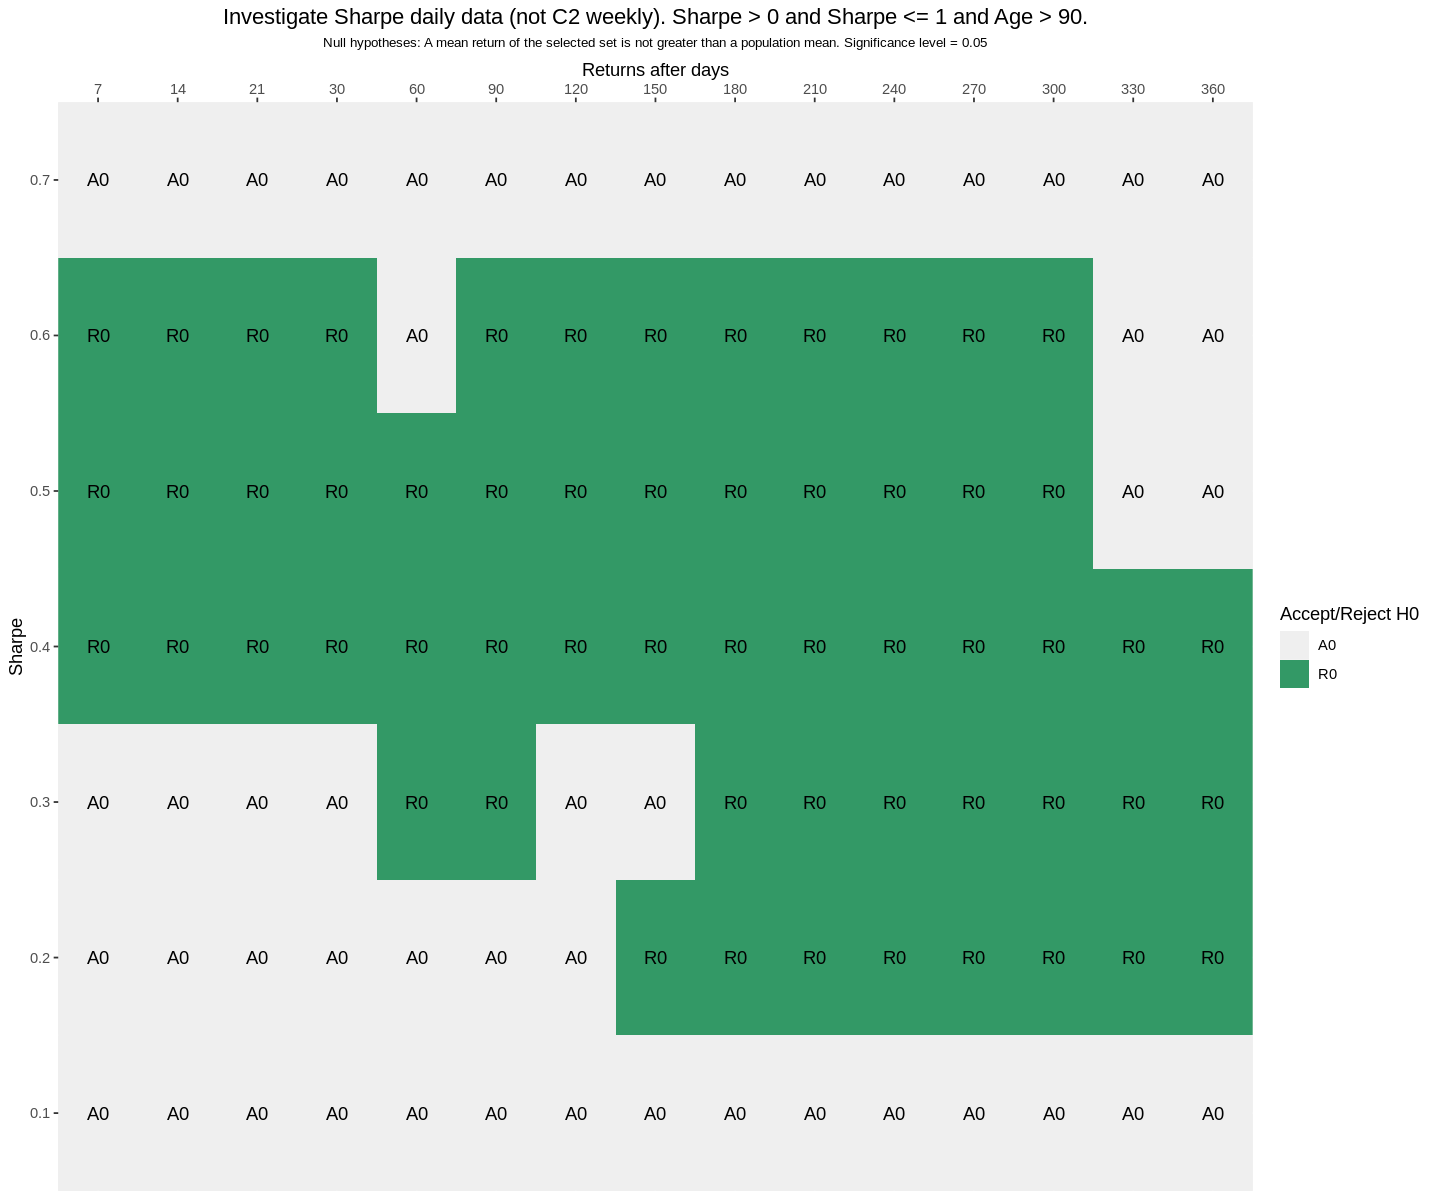

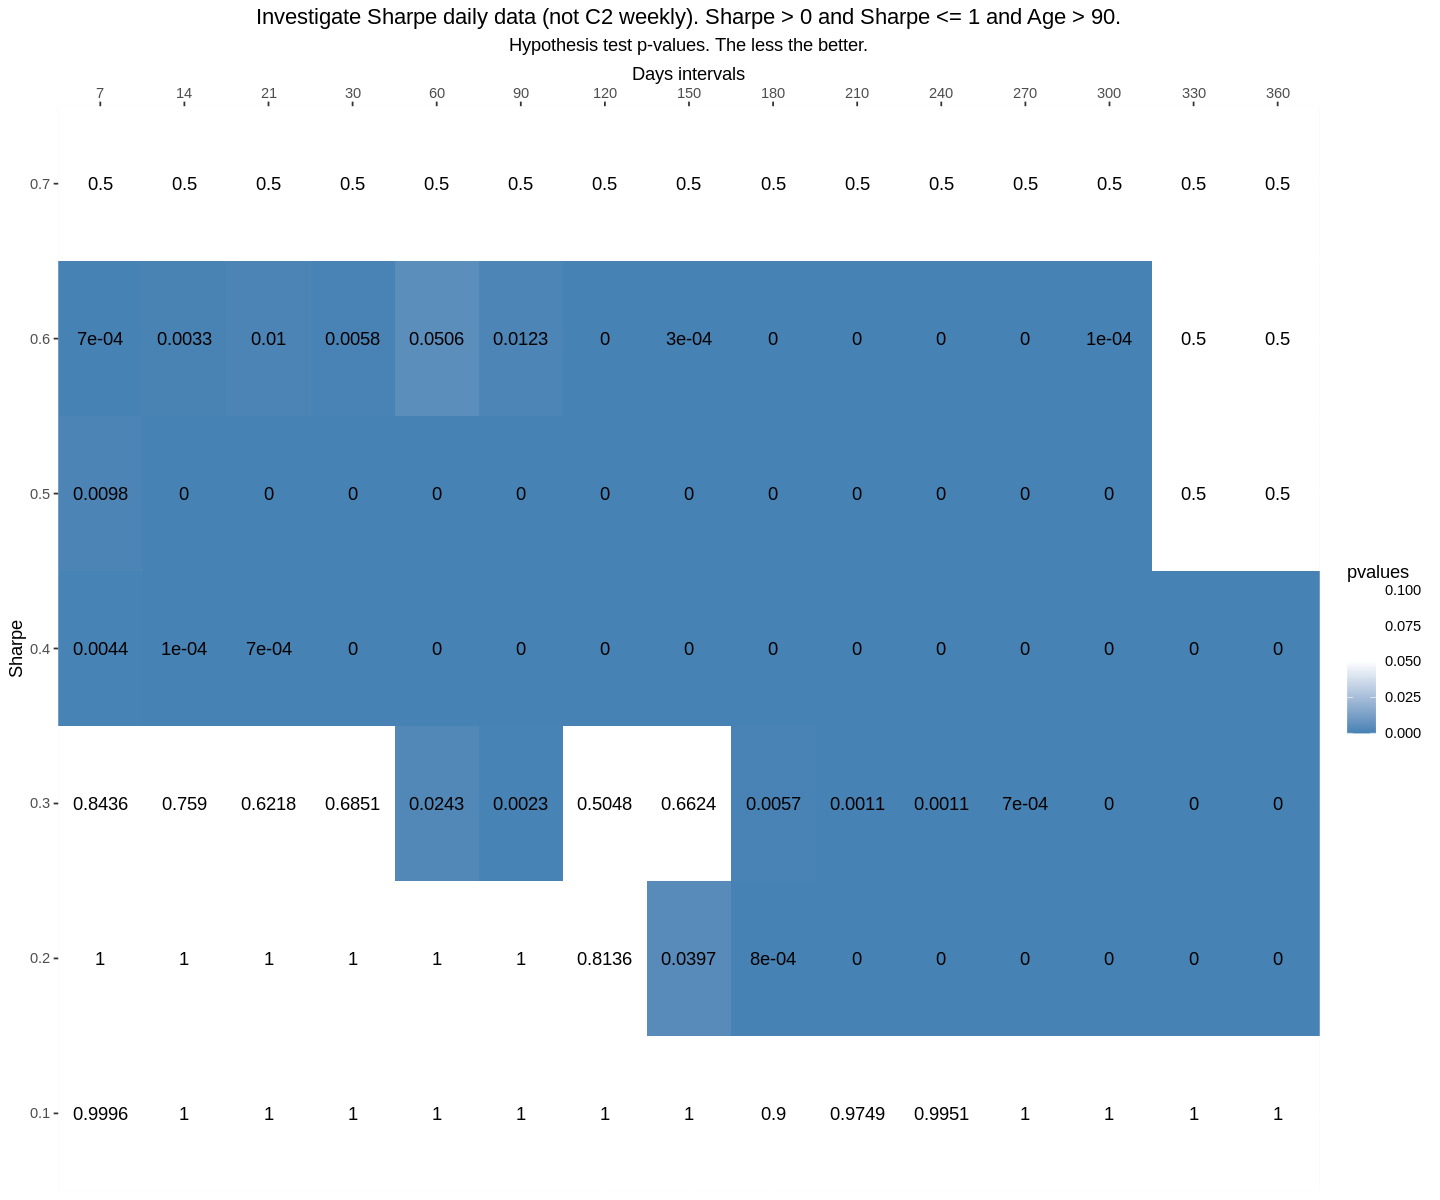

In [5]:
experiment = list(
  name = "Daily 0.1 < Sharpe <= 1 and Age > 90",
  description = "Investigate Sharpe daily data (not C2 weekly). Sharpe > 0 and Sharpe <= 1 and Age > 90.",
  sqlText = sql, # the last sql above
  attributeName = "Sharpe",
  attributeSteps = seq(from = 0.1, to = 0.7, by = 0.1),
  comparisonOperator = `>`)

result = makeExperiment(experiment)


Hypothesis test of sample standard deviation.

Alternative hypothesis: The sample standard deviation is less than the population SD.


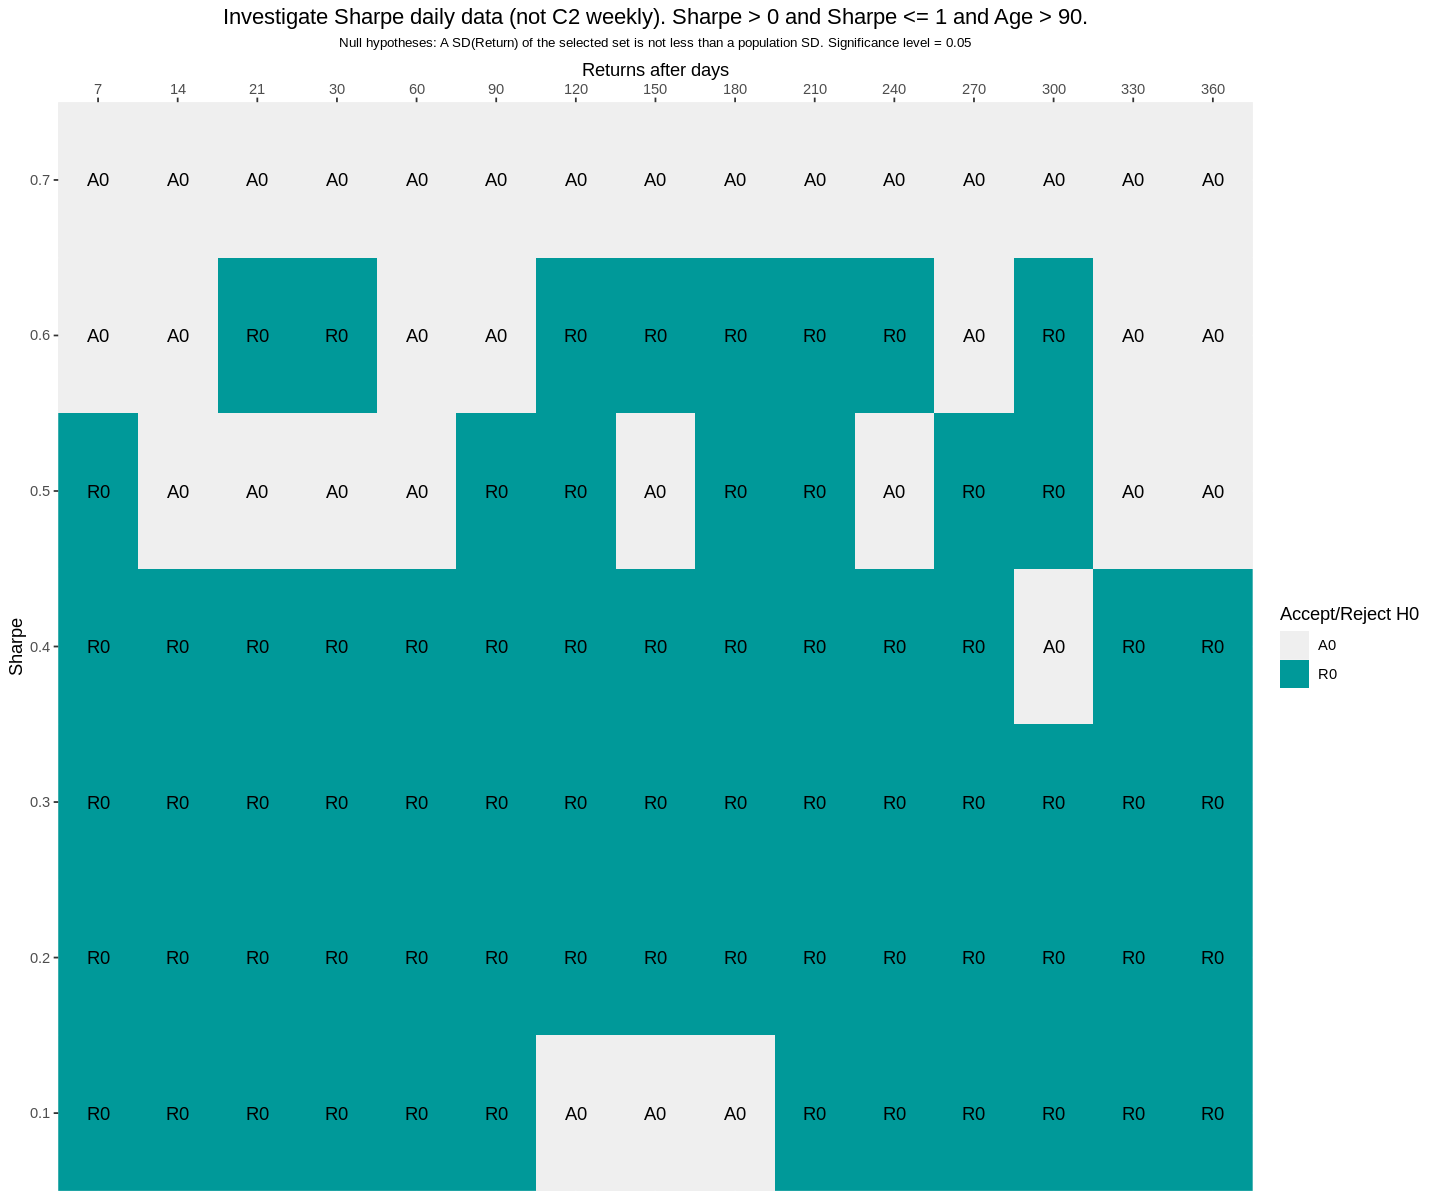

In [6]:
showSDLessHypothesisTest(experiment, result)

In [7]:
showObservationsCounts(experiment, result)


The following table contains numbers of observations in the used statistics intervals.
A number of observations in the sample is an important part of the hypothesis testing. Be careful if it is low (less than 30).
Numbers of observations shown in this table are NOT numbers of C2 strategies! Every strategy can have many observations in any statistics interval. That is what is shown here.


Selection,Obs007,Obs014,Obs021,Obs030,Obs060,Obs090,Obs120,Obs150,Obs180,Obs210,Obs240,Obs270,Obs300,Obs330,Obs360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.6 <= Sharpe < 0.7,48,48,48,48,48,48,48,48,34,31,31,14,4,0,0
0.5 <= Sharpe < 0.6,109,109,109,109,109,109,109,83,67,67,44,31,11,0,0
0.4 <= Sharpe < 0.5,368,361,354,344,283,244,209,171,141,91,80,80,63,61,61
0.3 <= Sharpe < 0.4,1296,1279,1261,1238,1075,916,747,639,544,493,463,403,367,346,330
0.2 <= Sharpe < 0.3,8774,8632,8485,8226,7309,6673,6107,5760,5409,4940,4304,3655,3239,2905,2542
0.1 <= Sharpe < 0.2,67904,66403,64779,62601,55559,49266,43920,39277,35368,31763,28199,25212,22633,20247,18227



SampleMetricValue minus PopulationMetricValue

This table shows differences between metric values calculated for the whole population and the current sample metric values. (See the chapter 'Population statistics'.)
This is different from our hypothesis test. Our hypothesis test tests an (alternative) hypothesis 'Is a mean of the sample greater than a mean of the population?'
But our metric is 'Mean divided by SD'. So the standard deviation plays a role in it.
Our metric is greater when a numerator is greater and/or denominator is less. It is up to you what you prefer.



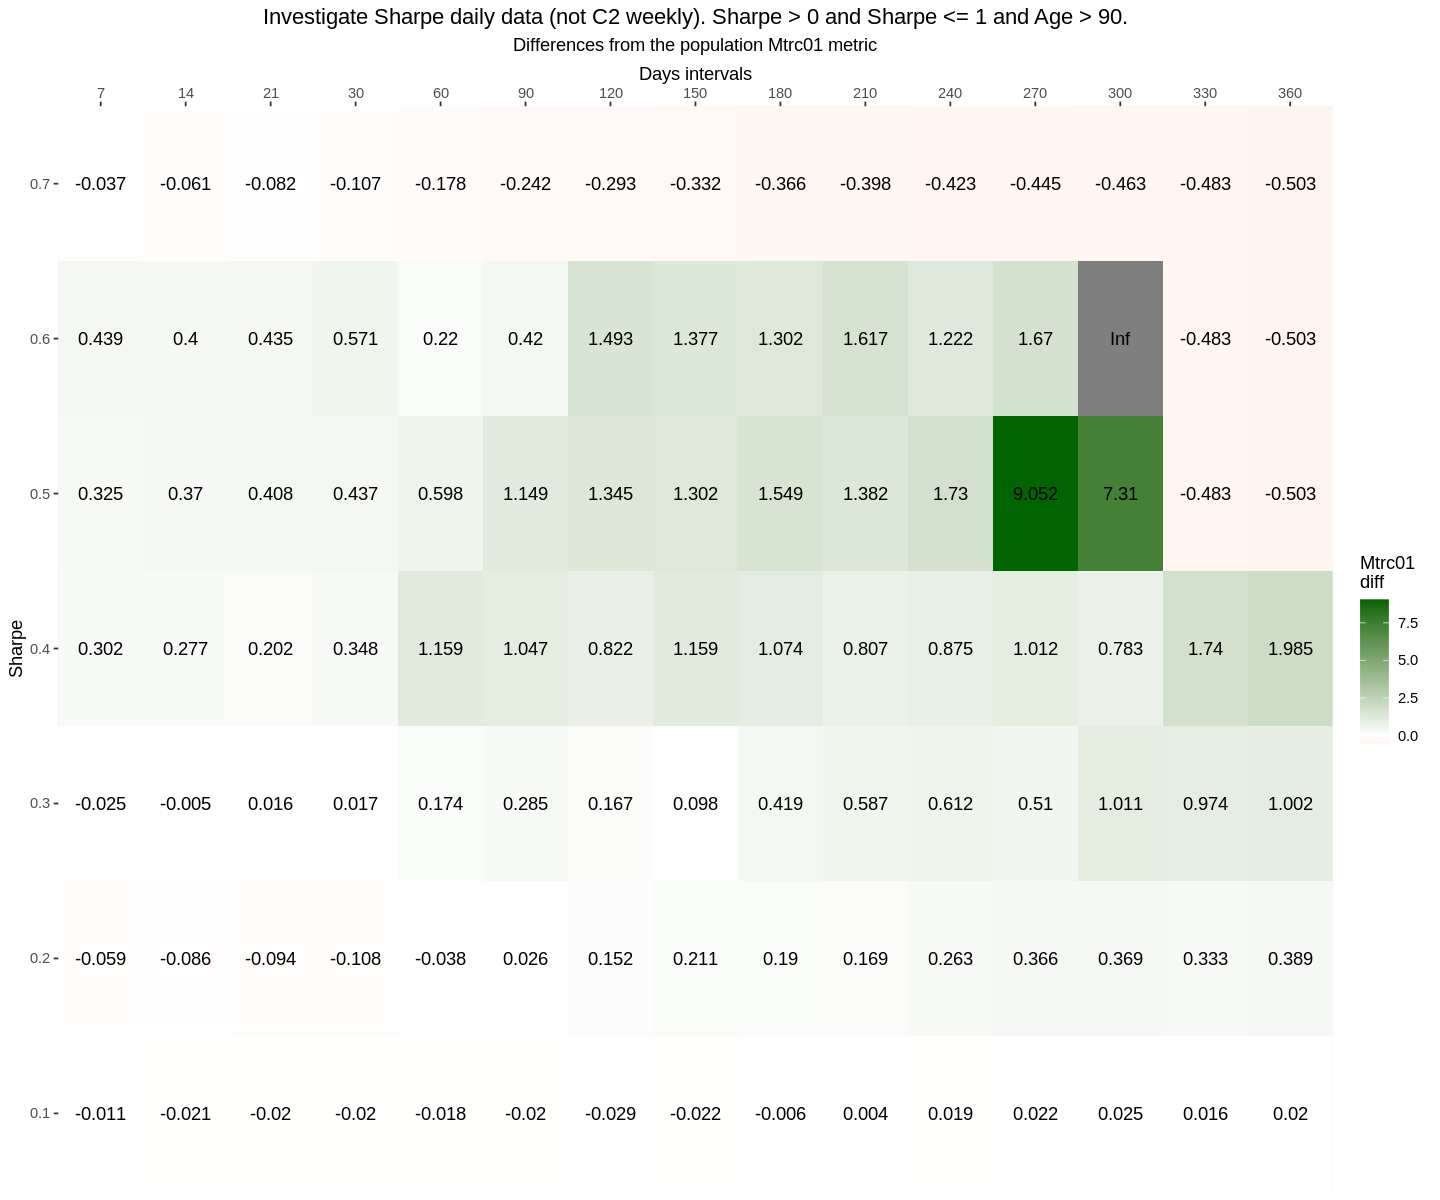

In [8]:
showMetricDifferences(experiment, result)

In [9]:
showSystemsCounts(experiment, result) 



Numbers of strategies observed in defined intervals.

Selection,Sys007,Sys014,Sys021,Sys030,Sys060,Sys090,Sys120,Sys150,Sys180,Sys210,Sys240,Sys270,Sys300,Sys330,Sys360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.6 <= Sharpe < 0.7,2,2,2,2,2,2,2,2,2,1,1,1,1,0,0
0.5 <= Sharpe < 0.6,2,2,2,2,2,2,2,2,1,1,1,1,1,0,0
0.4 <= Sharpe < 0.5,15,15,15,15,14,11,11,9,9,9,6,6,5,4,4
0.3 <= Sharpe < 0.4,59,59,58,58,51,41,37,33,30,27,25,21,19,18,16
0.2 <= Sharpe < 0.3,274,266,264,256,221,189,168,150,143,131,119,105,91,82,74
0.1 <= Sharpe < 0.2,921,892,869,828,696,595,522,460,414,370,338,291,257,230,215


### Discussion 

Sharpe 0.4 - 0.5 looks interesting. But the number of such systems in the C2 history is low.

It is surprising. May be some role plays a fact, that our Metric is very similar to Sharpe. So it is possible, that this test actually SHOULD accept the null hypothesis more times than we expected.

## Age > 180

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
         466       44365      0.1000      0.1126      0.1283      0.1417      0.1572      0.5319     0.04539 


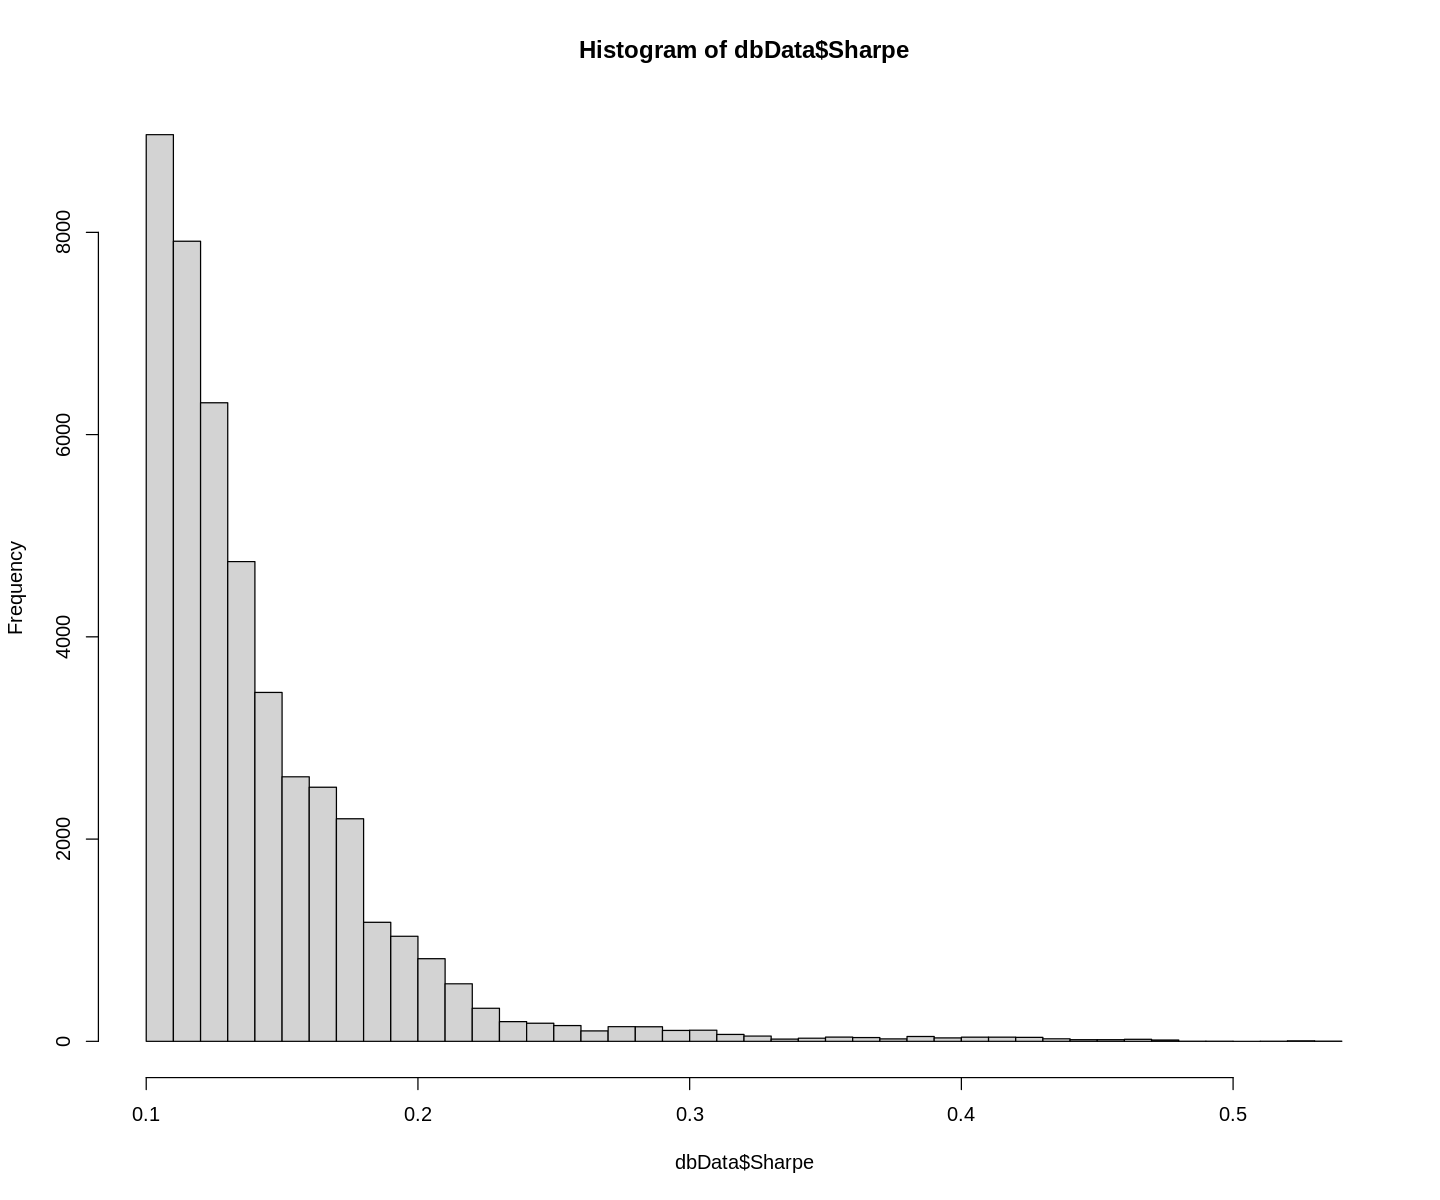

In [10]:
# Join it with our cleaned data and use Age > 180
sql = "select Sharpe, r.* 
       from ReturnsDataInIntervalsCleanedSkip090 r 
       join c2score_sharpe stat on stat.systemid=r.systemid and stat.Date = r.DateStart
       where Sharpe > 0.1 and Sharpe <= 1.0 and Age > 180"
dbData = getC2ScoreDbData(sql)
overview(dbData,"Sharpe")
hist(dbData$Sharpe,breaks=50)



We have calculated and stored the whole population statistics of strategies daily returns after 7, 14, ..., 360 days. Day after day. Now, we selected a particular statistics data (a sample) from the whole population. We want to know, if the average of returns of the sample is significantly higher than an average of returns of the whole population. A significance level is  0.05 .

The following table contains this hypothesis tests for defined stats intervals and all 7, 14, ..., 360 days time intervals.


Descriptive stats of all data selected in the experiment:
     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
         466       44365      0.1000      0.1126      0.1283      0.1417      0.1572      0.5319     0.04539 



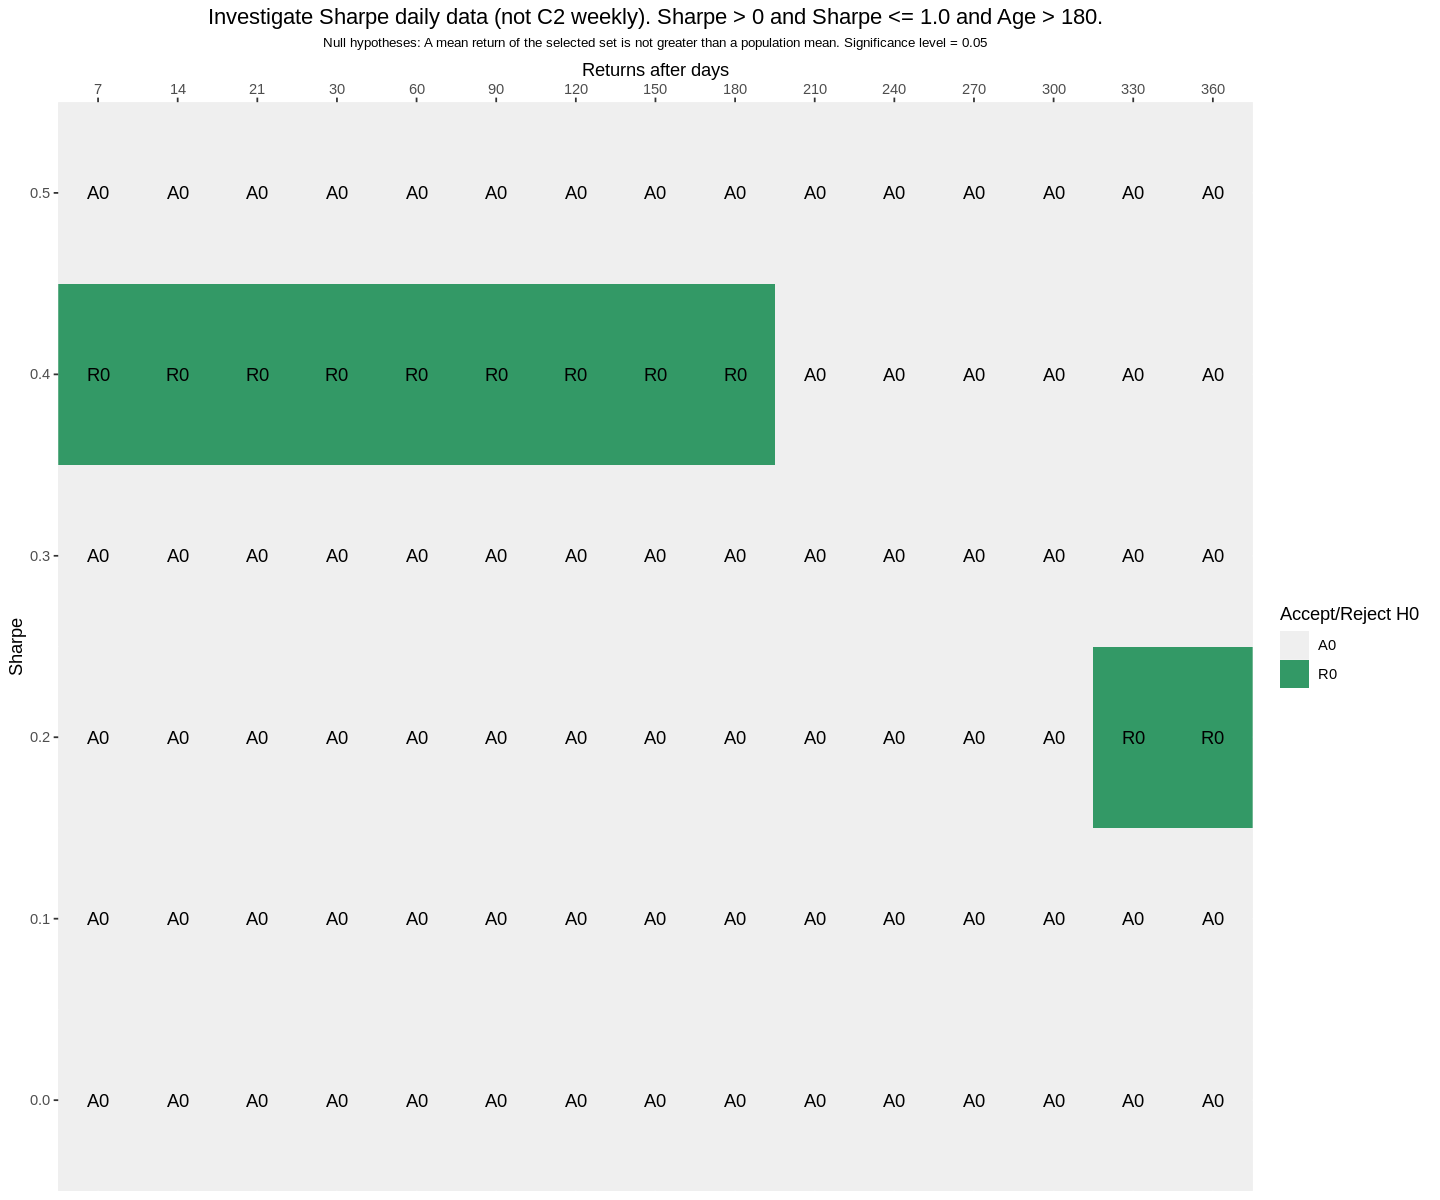

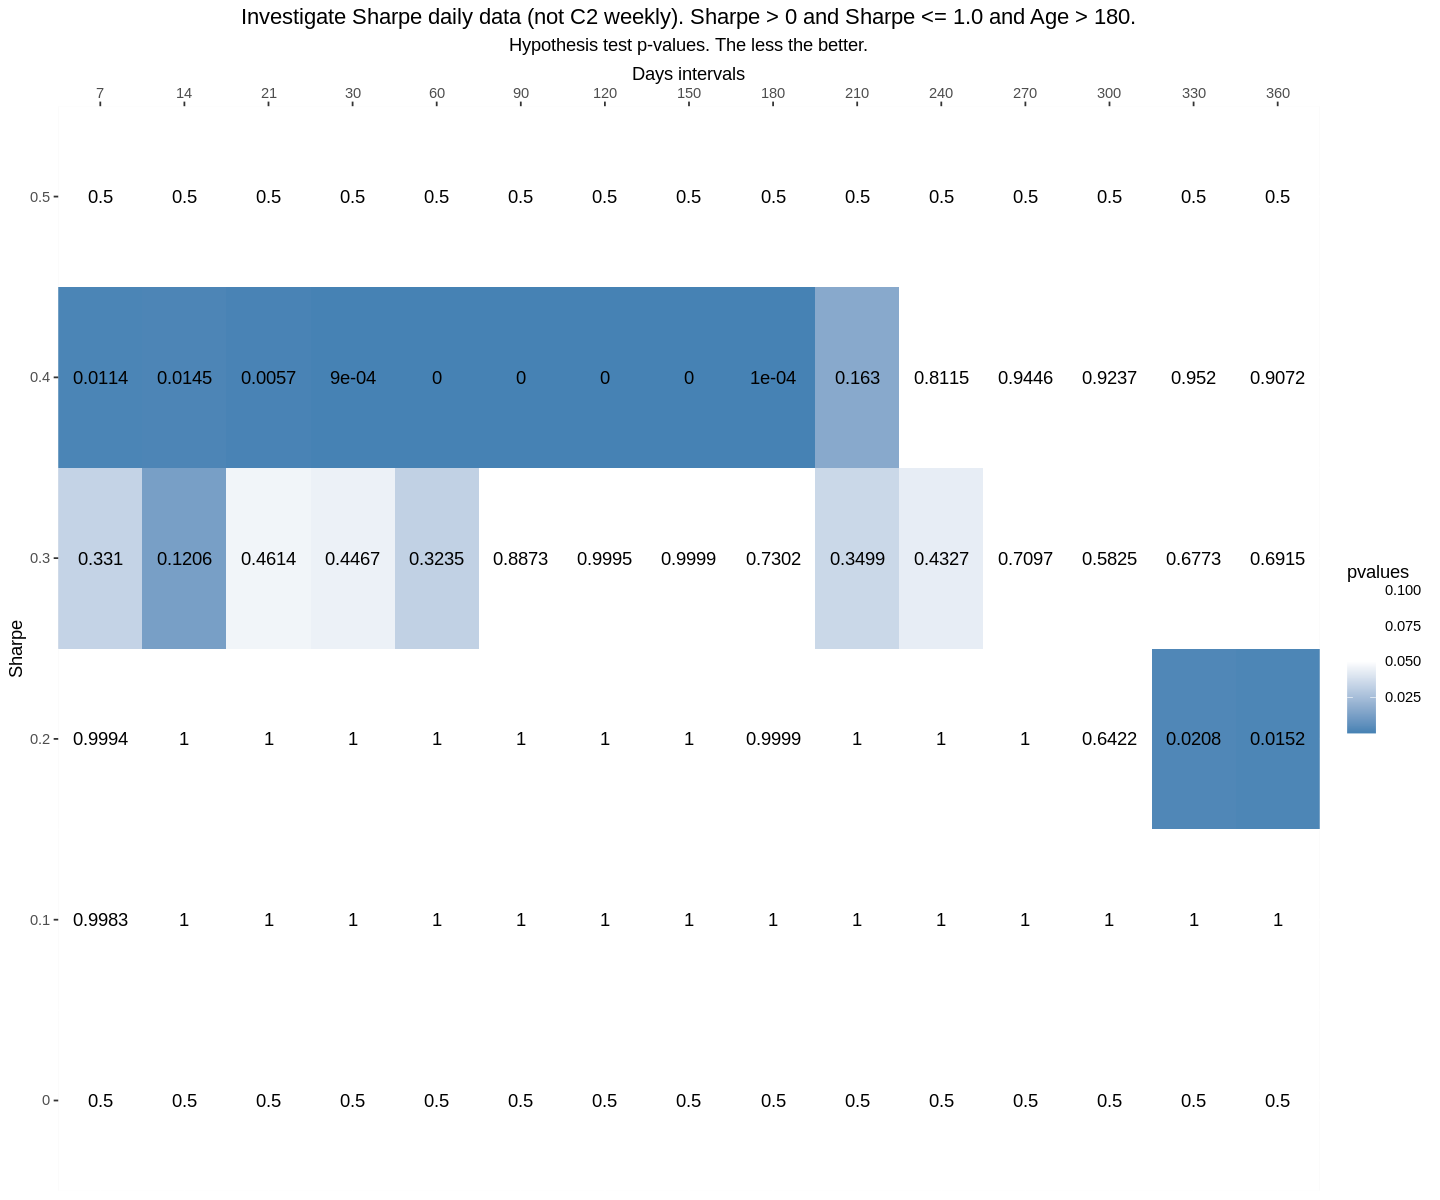

In [11]:
experiment = list(
  name = "Daily 0 < Sharpe <= 1.0 and Age > 180",
  description = "Investigate Sharpe daily data (not C2 weekly). Sharpe > 0 and Sharpe <= 1.0 and Age > 180.",
  sqlText = sql,
  attributeName = "Sharpe",
  attributeSteps = seq(from = 0, to = 0.55, by = 0.1),
  comparisonOperator = `>`)

result = makeExperiment(experiment)


Hypothesis test of sample standard deviation.

Alternative hypothesis: The sample standard deviation is less than the population SD.


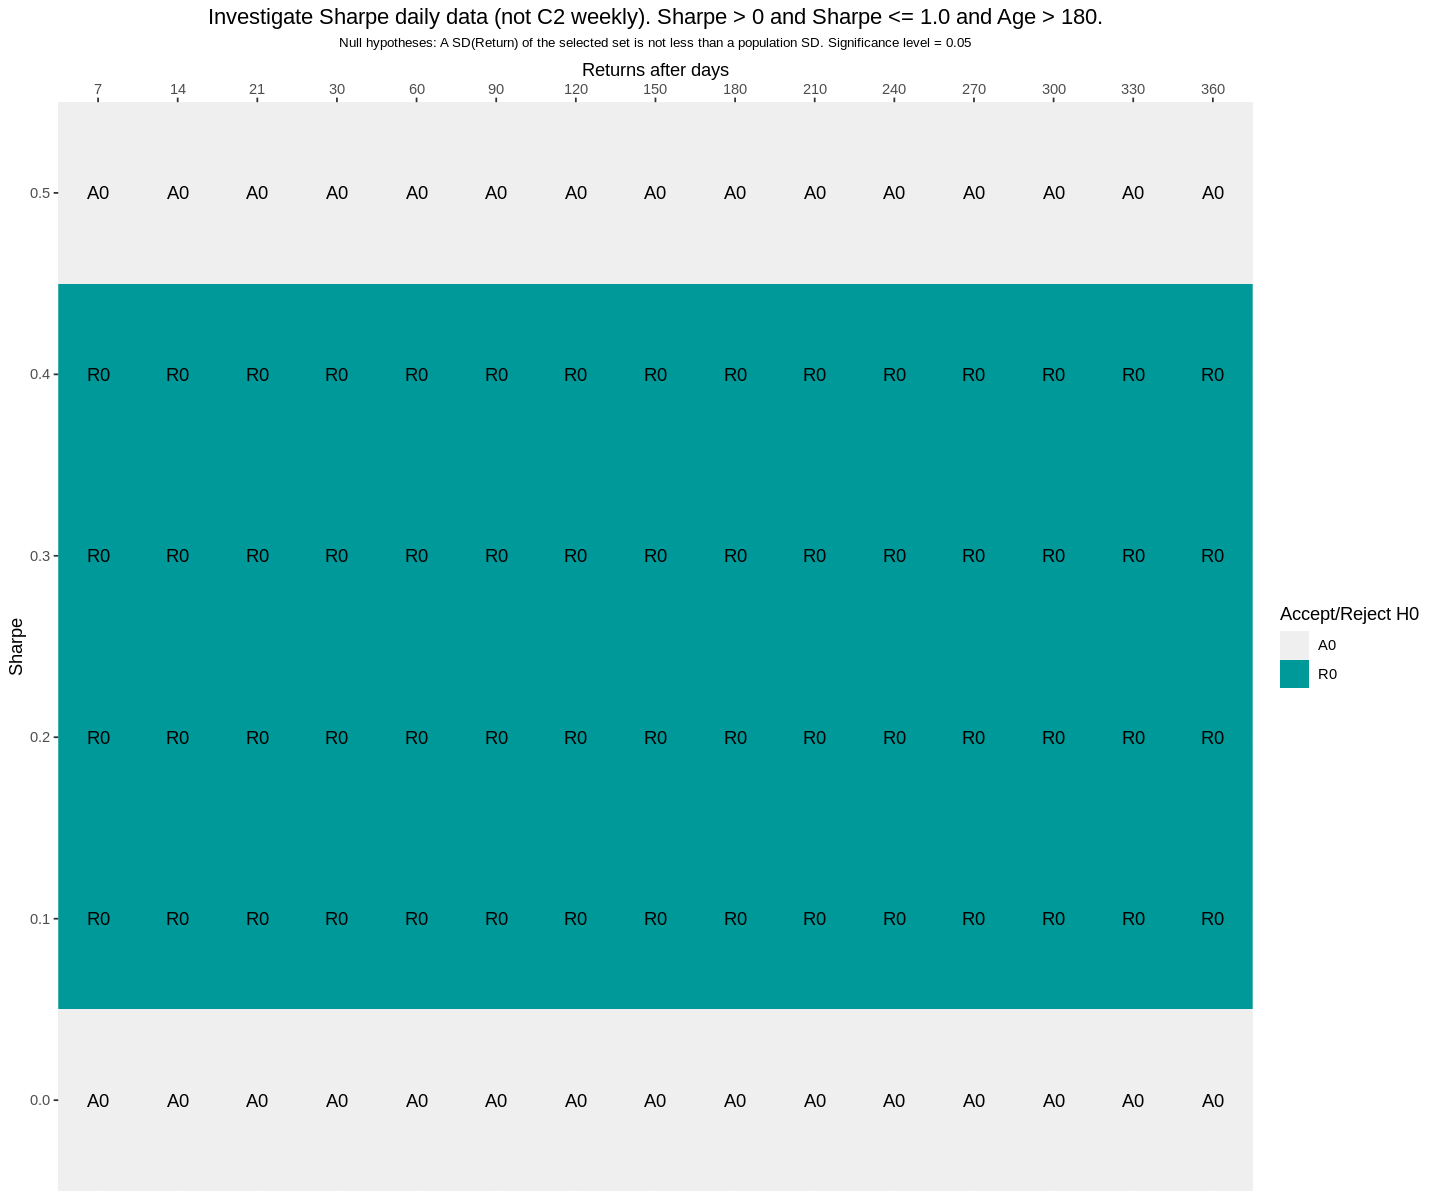

In [12]:
showSDLessHypothesisTest(experiment, result)

In [13]:
showObservationsCounts(experiment, result)


The following table contains numbers of observations in the used statistics intervals.
A number of observations in the sample is an important part of the hypothesis testing. Be careful if it is low (less than 30).
Numbers of observations shown in this table are NOT numbers of C2 strategies! Every strategy can have many observations in any statistics interval. That is what is shown here.


Selection,Obs007,Obs014,Obs021,Obs030,Obs060,Obs090,Obs120,Obs150,Obs180,Obs210,Obs240,Obs270,Obs300,Obs330,Obs360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.4 <= Sharpe < 0.5,206,199,192,182,141,105,98,68,38,8,1,1,1,1,1
0.3 <= Sharpe < 0.4,456,442,428,409,336,239,150,130,122,114,114,114,114,114,114
0.2 <= Sharpe < 0.3,2719,2681,2645,2592,2392,2181,2007,1874,1690,1496,1322,1165,1039,957,823
0.1 <= Sharpe < 0.2,40206,39479,38707,37688,34172,30732,27516,24572,22079,19901,18062,16438,15004,13545,12185
0 <= Sharpe < 0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



SampleMetricValue minus PopulationMetricValue

This table shows differences between metric values calculated for the whole population and the current sample metric values. (See the chapter 'Population statistics'.)
This is different from our hypothesis test. Our hypothesis test tests an (alternative) hypothesis 'Is a mean of the sample greater than a mean of the population?'
But our metric is 'Mean divided by SD'. So the standard deviation plays a role in it.
Our metric is greater when a numerator is greater and/or denominator is less. It is up to you what you prefer.



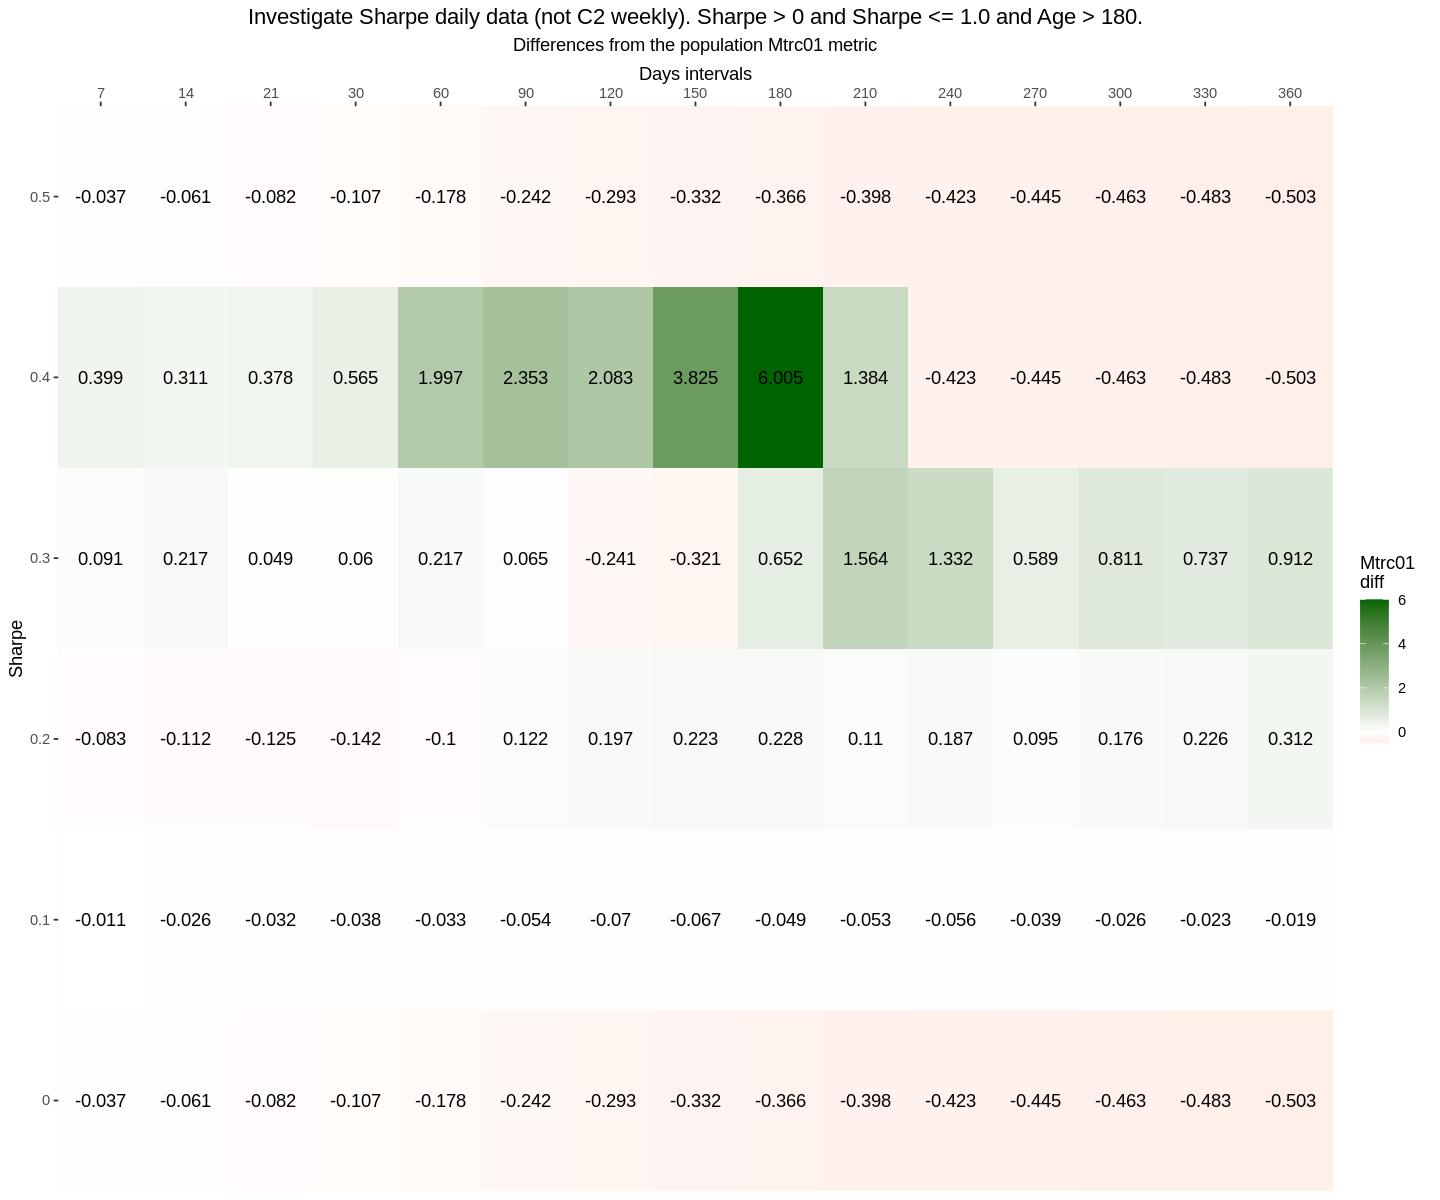

In [14]:
showMetricDifferences(experiment, result)

In [15]:
showSystemsCounts(experiment, result)



Numbers of strategies observed in defined intervals.

Selection,Sys007,Sys014,Sys021,Sys030,Sys060,Sys090,Sys120,Sys150,Sys180,Sys210,Sys240,Sys270,Sys300,Sys330,Sys360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.4 <= Sharpe < 0.5,5,5,5,5,5,3,2,2,2,2,1,1,1,1,1
0.3 <= Sharpe < 0.4,21,21,21,20,19,14,13,10,9,7,7,7,7,7,7
0.2 <= Sharpe < 0.3,75,75,74,73,69,62,56,53,51,45,40,36,34,30,28
0.1 <= Sharpe < 0.2,452,442,436,427,385,345,313,287,257,227,196,181,167,152,140
0 <= Sharpe < 0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Discussion 

Sharpe around 0.4 looks interesting. But the number of such systems in the C2 history is low.

It is surprising. May be some role plays a fact, that our Metric is very similar to Sharpe. So it is possible, that this test actually SHOULD accept the null hypothesis more times than we expected.